**Author: Fatma Moalla**\
**MVA 2019/2020**

In [145]:

import tensorflow as tf
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D,Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings('ignore')
from keras import backend as K

### I- Explore 

In [27]:
# Display audio
import IPython.display as ipd
ipd.Audio('dataset/Violin/am/am5.wav')

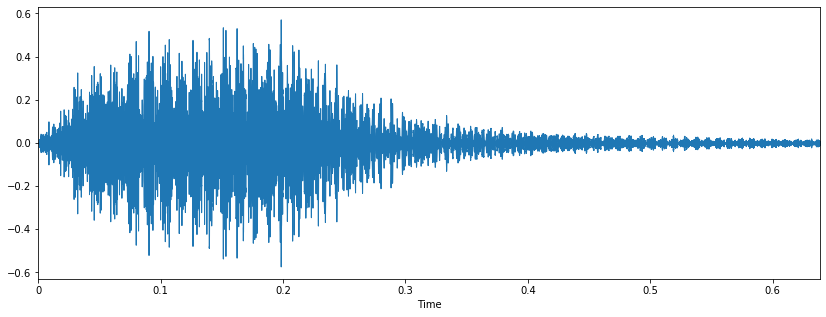

In [29]:
## Get the Mel-f-banks spectrogram og a given violin video

# Example of a Siren spectrogram


y, sr = librosa.load('dataset/Violin/am/am5.wav',duration=2)
spec = librosa.feature.melspectrogram(y=y, sr=sr)
spec.shape
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)


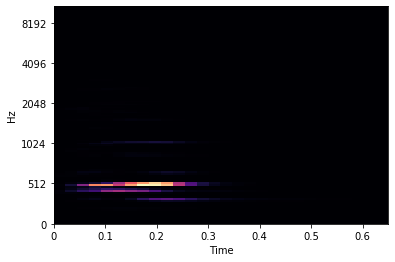

In [30]:
librosa.display.specshow(spec, y_axis='mel', x_axis='time')

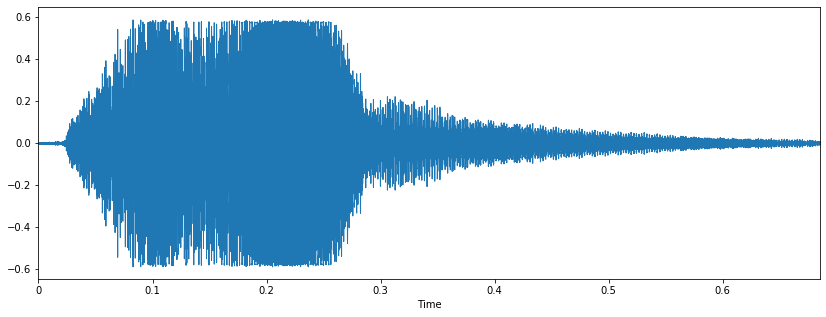

In [34]:
## Get the Mel-f-banks spectrogram og a given violin video

# Example of a Siren spectrogram


y, sr = librosa.load('dataset/Violin/f/f10.wav',duration=2)
spec = librosa.feature.melspectrogram(y=y, sr=sr)
spec.shape
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)


In [36]:
ipd.Audio('dataset/Violin/f/f10.wav')

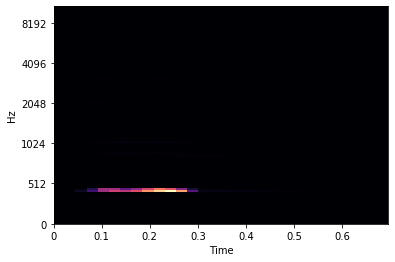

In [35]:
librosa.display.specshow(spec, y_axis='mel', x_axis='time')

# II- Train

In [24]:
# Violin_Chords contains the labels of the f
data = pd.read_csv('./chords.csv')
data.head(5)

,file_name,classID,classname
0,a1.wav,0,a
1,a2.wav,0,a
2,a3.wav,0,a
3,a4.wav,0,a
4,a5.wav,0,a


In [37]:
data = pd.DataFrame(np.zeros((100,3)),columns=['file_name', 'id_class','name_class'])

In [55]:
class_dict = {'a':0,'am':1,'bm':2,'c':3,'d':4,'dm':5,'e':6,'em':7, 'f':8,'g':9}
k=0
for label in class_dict.keys():

    for i in range(1,11):
        data.loc[k+i-1,'file_name'] = str(label)+str(i)+'.wav'
        data.loc[k+i-1,'id_class'] = int(class_dict[label])
        data.loc[k+i-1,'name_class'] = label
    k+=10
        
   

In [56]:
class_dict.keys()

dict_keys(['a', 'am', 'bm', 'c', 'd', 'dm', 'e', 'em', 'f', 'g'])

In [58]:
data.head()

,file_name,id_class,name_class
0,a1.wav,0.0,a
1,a2.wav,0.0,a
2,a3.wav,0.0,a
3,a4.wav,0.0,a
4,a5.wav,0.0,a


In [61]:
val_data = data.copy()
val_data['path'] =  val_data['name_class'].astype('str') + '/' + val_data['file_name'].astype('str')

In [62]:
val_data.head()

,file_name,id_class,name_class,path
0,a1.wav,0.0,a,a/a1.wav
1,a2.wav,0.0,a,a/a2.wav
2,a3.wav,0.0,a,a/a3.wav
3,a4.wav,0.0,a,a/a4.wav
4,a5.wav,0.0,a,a/a5.wav


In [120]:
D = [] # Dataset
### Added padding to have the same length
maxi = 72
n=128
for row in val_data.itertuples():
    y, sr = librosa.load('dataset/Violin/' + row.path,duration=2)  
    ps0 = librosa.feature.melspectrogram(y=y, sr=sr)
    if  np.shape(ps0)[1]<maxi:
        ps = np.concatenate((ps0,np.zeros((n,maxi-np.shape(ps0)[1]))),axis=1)
    D.append( (ps, row.id_class) )

In [74]:
# Divide training and testing sets
dataset = D.copy()
random.shuffle(dataset)

train = dataset[:80]
test = dataset[20:]

In [79]:
X_train, y_train = zip(*train)
X_test, y_test = zip(*test)
print(X_train[0].shape)


(128, 72)


In [80]:
# Reshape for CNN input
X_train = np.array([x.reshape( (n, maxi, 1) ) for x in X_train])
X_test = np.array([x.reshape( (n, maxi, 1) ) for x in X_test])



In [81]:
# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test_values=y_test
y_test = np.array(keras.utils.to_categorical(y_test, 10))



In [90]:
model = Sequential()
input_shape=(n, maxi, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activaton('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.4))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.4))

model.add(Dense(10))
model.add(Activation('softmax'))

In [91]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 68, 24)       624       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 34, 24)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 31, 34, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 30, 48)        28848     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 15, 48)         0         
_________________________________________________________________
activation_7 (Activation)    (None, 6, 15, 48)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4320)             

In [92]:
# Define all the metrics to use 


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

In [93]:
# Train the model
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=70,
    batch_size=20,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test f1-score:', score[4])


Train on 80 samples, validate on 80 samples
Epoch 1/70
80/80 [==============================] - 1s 16ms/step - loss: 8.5817 - accuracy: 0.1375 - precision: 0.1567 - recall: 0.1375 - fmeasure: 0.1461 - val_loss: 5.7855 - val_accuracy: 0.2000 - val_precision: 0.2561 - val_recall: 0.2000 - val_fmeasure: 0.2242
Epoch 2/70
80/80 [==============================] - 1s 11ms/step - loss: 6.2792 - accuracy: 0.1750 - precision: 0.2064 - recall: 0.1500 - fmeasure: 0.1731 - val_loss: 3.1519 - val_accuracy: 0.5250 - val_precision: 0.5857 - val_recall: 0.3750 - val_fmeasure: 0.4549
Epoch 3/70
80/80 [==============================] - 1s 11ms/step - loss: 4.5888 - accuracy: 0.2625 - precision: 0.2366 - recall: 0.1750 - fmeasure: 0.2005 - val_loss: 2.8440 - val_accuracy: 0.4875 - val_precision: 0.5393 - val_recall: 0.3750 - val_fmeasure: 0.4417
Epoch 4/70
80/80 [==============================] - 1s 11ms/step - loss: 4.1683 - accuracy: 0.3500 - precision: 0.3371 - recall: 0.2375 - fmeasure: 0.2776 - val_

In [94]:
predictions = model.predict_classes(X_test)
print('The predictions are', predictions)
y_test_values=np.array(y_test_values)
print('The ground-truth are', y_test_values)


The predictions are [4 3 1 5 6 8 9 4 4 9 5 1 1 7 2 1 0 8 2 3 5 5 3 3 6 7 9 0 4 8 2 5 8 8 8 6 5
 8 2 0 9 4 8 2 4 5 2 8 9 3 4 0 1 3 4 6 1 9 0 1 3 6 6 6 3 0 1 4 0 0 2 3 1 0
 7 2 6 7 1 1]
The ground-truth are [4. 3. 1. 5. 6. 8. 9. 4. 4. 9. 5. 1. 1. 7. 2. 1. 0. 8. 2. 3. 5. 5. 3. 3.
 6. 7. 9. 0. 4. 8. 2. 5. 8. 8. 8. 6. 5. 8. 2. 0. 9. 4. 8. 2. 4. 5. 2. 8.
 9. 3. 4. 0. 1. 3. 4. 6. 1. 9. 0. 1. 3. 6. 7. 6. 3. 0. 1. 4. 0. 0. 2. 3.
 1. 0. 7. 2. 6. 7. 1. 3.]


In [95]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y_test_values, predictions, labels=[0,1,2,3,4,5,6,7,8,9])
print(conf_matrix)

[[ 9  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0]
 [ 0  1  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  1  4  0  0]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0  6]]


# III- Effect of Data augmentation:

In [107]:
# speed variation
rate = 1.05 # replace with 0.81 and execute again

for row in val_data.itertuples():
    y, sr = librosa.load('dataset/Violin/' + row.path)  
    y_changed = librosa.effects.time_stretch(y, rate=rate)
    librosa.output.write_wav('dataset/Violin/' + str(row.name_class) + '/' +'speed_'+row.file_name,y_changed, sr)

In [108]:
# Display audio
import IPython.display as ipd
ipd.Audio('dataset/Violin/am/speed_am5.wav')

In [109]:
# pitch shift


n_steps = -1 #-1, -2, 2, 1

for row in val_data.itertuples():
    y, sr = librosa.load('dataset/Violin/' + row.path)  
    y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
    librosa.output.write_wav('dataset/Violin/' + str(row.name_class) + '/' +'pitch_'+ row.file_name ,y_changed, sr)

In [110]:
# Display audio
import IPython.display as ipd
ipd.Audio('dataset/Violin/am/pitch_am5.wav')

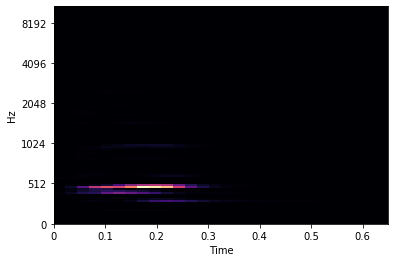

In [112]:
# Example of a Siren spectrogram
y, sr = librosa.load('dataset/Violin/am/pitch_am5.wav',duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [121]:
print(D)

[(array([[7.43533149e-02, 6.05892837e-01, 2.47376728e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.53189544e-02, 1.12503218e-02, 5.95552986e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.21839317e-03, 3.36780795e-03, 1.26411673e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.20377855e-03, 1.19162677e-03, 1.46219507e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.53214535e-04, 4.89552913e-04, 5.94042358e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.51901347e-05, 4.18173404e-05, 9.31849936e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]), 0.0), (array([[2.11172178e-02, 6.07719040e-03, 2.38557928e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.77363977e-02, 5.09056216e-03, 7.26834463e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.71190133e-03, 3.2332669

In [125]:
### Added padding to have the same length
maxi = 72
n=128
for i,row in enumerate(val_data.itertuples()):
    y, sr = librosa.load('dataset/Violin/' +val_data.loc[i,'name_class']+'/'+'pitch_'+val_data.loc[i,'file_name'],duration=2)  
    ps0 = librosa.feature.melspectrogram(y=y, sr=sr)
    if  np.shape(ps0)[1]<maxi:
        ps = np.concatenate((ps0,np.zeros((n,maxi-np.shape(ps0)[1]))),axis=1)
    D.append( (ps, row.id_class) )

[ 0.00094711 -0.00218786 -0.00682411 ...  0.00048325 -0.00140105
  0.        ] 22050
[0.03500111 0.05764376 0.05630618 ... 0.00042102 0.00296392 0.        ] 22050
[ 0.0024951   0.00615671  0.00137896 ...  0.00228844 -0.00247336
  0.        ] 22050
[-0.00357263 -0.0088609  -0.00805867 ... -0.002834   -0.00230572
  0.        ] 22050
[-0.00292336 -0.00180998 -0.00104922 ...  0.00666889  0.00759704
  0.        ] 22050
[-0.00227973 -0.00249314 -0.00048286 ... -0.00136244 -0.00325952
 -0.00387795] 22050
[-0.00220982 -0.00694336 -0.00950665 ...  0.00594113  0.0079757
  0.00652218] 22050
[-0.00626261 -0.00012355  0.00046842 ...  0.00504438  0.00597649
  0.        ] 22050
[ 0.00358714  0.00541731  0.00753082 ... -0.0109066  -0.00981969
 -0.00988897] 22050
[-0.00390371  0.00286414  0.01321035 ... -0.00586132 -0.00318081
  0.        ] 22050
[ 0.0088198   0.01151419  0.01089058 ... -0.0066436  -0.00711671
  0.        ] 22050
[-0.00103155 -0.00194426 -0.00340166 ... -0.00831048 -0.011312
  0.      

In [139]:
# Divide training and testing sets
dataset = D.copy()
random.shuffle(dataset)

train = dataset[:160]
test = dataset[40:]

In [140]:
X_train, y_train = zip(*train)
X_test, y_test = zip(*test)
print(X_train[0].shape)
X_train, y_train = zip(*train)
X_test, y_test = zip(*test)
print(X_train[0].shape)
# Reshape for CNN input
X_train = np.array([x.reshape( (n, maxi, 1) ) for x in X_train])
X_test = np.array([x.reshape( (n, maxi, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test_values=y_test
y_test = np.array(keras.utils.to_categorical(y_test, 10))



(128, 72)
(128, 72)


In [141]:
model = Sequential()
input_shape=(n, maxi, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.4))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.4))

model.add(Dense(10))
model.add(Activation('softmax'))

In [142]:
# Train the model
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=70,
    batch_size=20,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)


print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test f1-score:', score[4])


Train on 160 samples, validate on 260 samples
Epoch 1/70
160/160 [==============================] - 3s 16ms/step - loss: 9.2220 - accuracy: 0.1312 - precision: 0.1291 - recall: 0.1125 - fmeasure: 0.1200 - val_loss: 5.0801 - val_accuracy: 0.2615 - val_precision: 0.2605 - val_recall: 0.2038 - val_fmeasure: 0.2280
Epoch 2/70
160/160 [==============================] - 2s 11ms/step - loss: 5.6875 - accuracy: 0.2313 - precision: 0.2544 - recall: 0.2000 - fmeasure: 0.2236 - val_loss: 3.0312 - val_accuracy: 0.3846 - val_precision: 0.5477 - val_recall: 0.3154 - val_fmeasure: 0.3961
Epoch 3/70
160/160 [==============================] - 2s 15ms/step - loss: 3.8567 - accuracy: 0.3313 - precision: 0.4124 - recall: 0.2875 - fmeasure: 0.3371 - val_loss: 2.5466 - val_accuracy: 0.4154 - val_precision: 0.5946 - val_recall: 0.2962 - val_fmeasure: 0.3895
Epoch 4/70
160/160 [==============================] - 3s 17ms/step - loss: 2.8997 - accuracy: 0.3812 - precision: 0.5392 - recall: 0.2688 - fmeasure: 0.3

In [143]:
predictions1 = model.predict_classes(X_test)
print('The predictions are', predictions1)
y_test_values=np.array(y_test_values)
print('The ground-truth are', y_test_values)


The predictions are [4 1 7 6 0 9 3 5 6 3 7 6 8 1 1 3 0 5 3 9 8 6 1 1 1 5 6 1 9 6 1 2 4 0 8 9 8
 2 2 9 3 6 3 4 6 7 8 6 3 1 3 5 4 6 7 2 8 9 6 8 3 5 3 0 1 5 4 8 6 1 9 3 4 1
 4 5 8 6 3 7 2 6 4 1 6 2 7 1 8 4 6 1 8 9 9 3 5 8 3 1 6 5 2 3 9 0 0 3 2 4 8
 8 5 8 1 8 7 5 7 0 4 7 8 3 0 0 7 9 0 8 4 9 9 0 4 0 4 6 0 1 6 7 3 6 9 3 8 5
 9 5 9 5 4 9 6 6 6 0 0 4 1 4 7 0 2 7 2 7 8 6 9 3 3 0 0 5 2 6 0 2 9 7 5 0 8
 5 8 7 3 1 2 0 0 0 2 2 7 2 1 9 7 7 1 4 5 7 4 9 7 5 6 1 7 2 4 8 5 4 8 7 5 9
 2 5 2 0 2 9 9 4 9 0 2 3 4 1 2 1 0 8 4 0 6 2 3 7 5 5 5 5 2 8 9 7 5 1 4 9 2
 8]
The ground-truth are [4. 1. 7. 6. 0. 9. 3. 5. 6. 3. 7. 6. 8. 1. 1. 3. 0. 5. 3. 9. 8. 6. 1. 1.
 1. 5. 6. 1. 9. 6. 1. 2. 4. 0. 8. 9. 8. 2. 2. 9. 3. 6. 3. 4. 6. 7. 8. 6.
 3. 1. 3. 5. 4. 6. 7. 2. 8. 9. 6. 8. 3. 5. 3. 0. 1. 5. 4. 8. 6. 1. 9. 3.
 4. 1. 4. 5. 8. 6. 3. 7. 2. 6. 4. 1. 6. 2. 7. 1. 8. 4. 6. 1. 8. 9. 9. 3.
 5. 8. 3. 1. 6. 5. 2. 3. 9. 0. 0. 3. 2. 4. 8. 8. 5. 8. 1. 8. 7. 5. 7. 0.
 4. 7. 8. 3. 0. 0. 7. 9. 0. 8. 4. 9. 9. 0. 4. 0. 4. 6. 0. 1. 6. 7

In [144]:
conf_matrix=confusion_matrix(y_test_values, predictions1, labels=[0,1,2,3,4,5,6,7,8,9])
print(conf_matrix)

[[26  0  0  0  0  0  0  0  0  0]
 [ 1 26  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  2  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0 27  0  0  0  0]
 [ 0  0  0  1  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  0 27]]


In [148]:
# Get metrics per class

results= sklearn.metrics.precision_recall_fscore_support(y_test_values,  predictions1, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'))
precision = results[0]
recall = results[1]
fscore = results[2]
np.mean(fscore)